#Higgs Boson Machine Learning Challenge(Kaggle)


Welcome to the "Higgs Boson Selection Challenge" analysis, where we delve into the Higgs boson dataset using a diverse array of machine learning algorithms, including MLPs, CNNs, XGBoost, and transformers. Our quest is to identify the most effective algorithm to tackle this challenge. To determine the best-performing model, we rely on the Area Under the Curve (AUC) metric. Additionally, we'll rank the variables using the Shapley method, providing valuable insights into the dataset's feature importance.

In [1]:
# The following packages are required for this notebook but they do are not pre-installed on colab
%%capture
!pip install -q kaggle
!pip install optuna
!pip install optuna-integration
!pip install shap

#Importing the data
Create a Kaggle account and visit the link (https://www.kaggle.com/competitions/higgs-boson/data). Accept the challenge. The following image shows a screenshot of the "Join the competition". 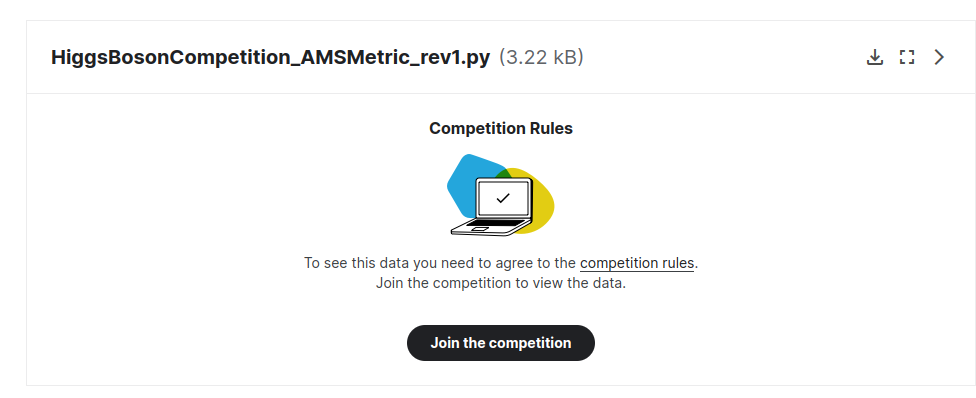


One should create a Kaggle account  (https://www.kaggle.com/username/account)
and create a New API Token.
One should download it on personal laptop and then use that .json file in the following line.

In [2]:
from google.colab import files
#Choose file should be the downloaded .json file from kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"janmajaykumar","key":"303ae1d6d6dd04b357aa7c364b59fb75"}'}

In [3]:
# a directory will be created and the higgs data will be downloaded into it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c higgs-boson
#unzip the data
!unzip higgs-boson.zip
!ls

 61% 33.0M/54.3M [00:00<00:00, 137MB/s] 
100% 54.3M/54.3M [00:00<00:00, 157MB/s]
Archive:  higgs-boson.zip
  inflating: HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: random_submission.zip   
  inflating: test.zip                
  inflating: training.zip            
HiggsBosonCompetition_AMSMetric_rev1.py  kaggle.json		sample_data  training.zip
higgs-boson.zip				 random_submission.zip	test.zip


#Importing libraries
Certain libraries will be required in order to run this notebook such as numpy and pandas for data manipulation. Similarly matplotlib will be used for plotting while scikit learn will be used for evaluation of the ML model and preprocessing. MPL and CNN algorithms, i.e. different layers, will be imported from tensorflow.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import roc_curve, auc
#from HP_OPT_class import HP_OPT_class_code, plot_tools
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
import os
import warnings
import optuna
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier

In [5]:
# The data is converted to pandas dataframes
df_train = pd.read_csv('training.zip', compression='zip')
df_test = pd.read_csv('test.zip', compression='zip')

In [8]:


# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        # Set memory growth to True to allocate memory only as needed
        tf.config.experimental.set_memory_growth(gpu, True)



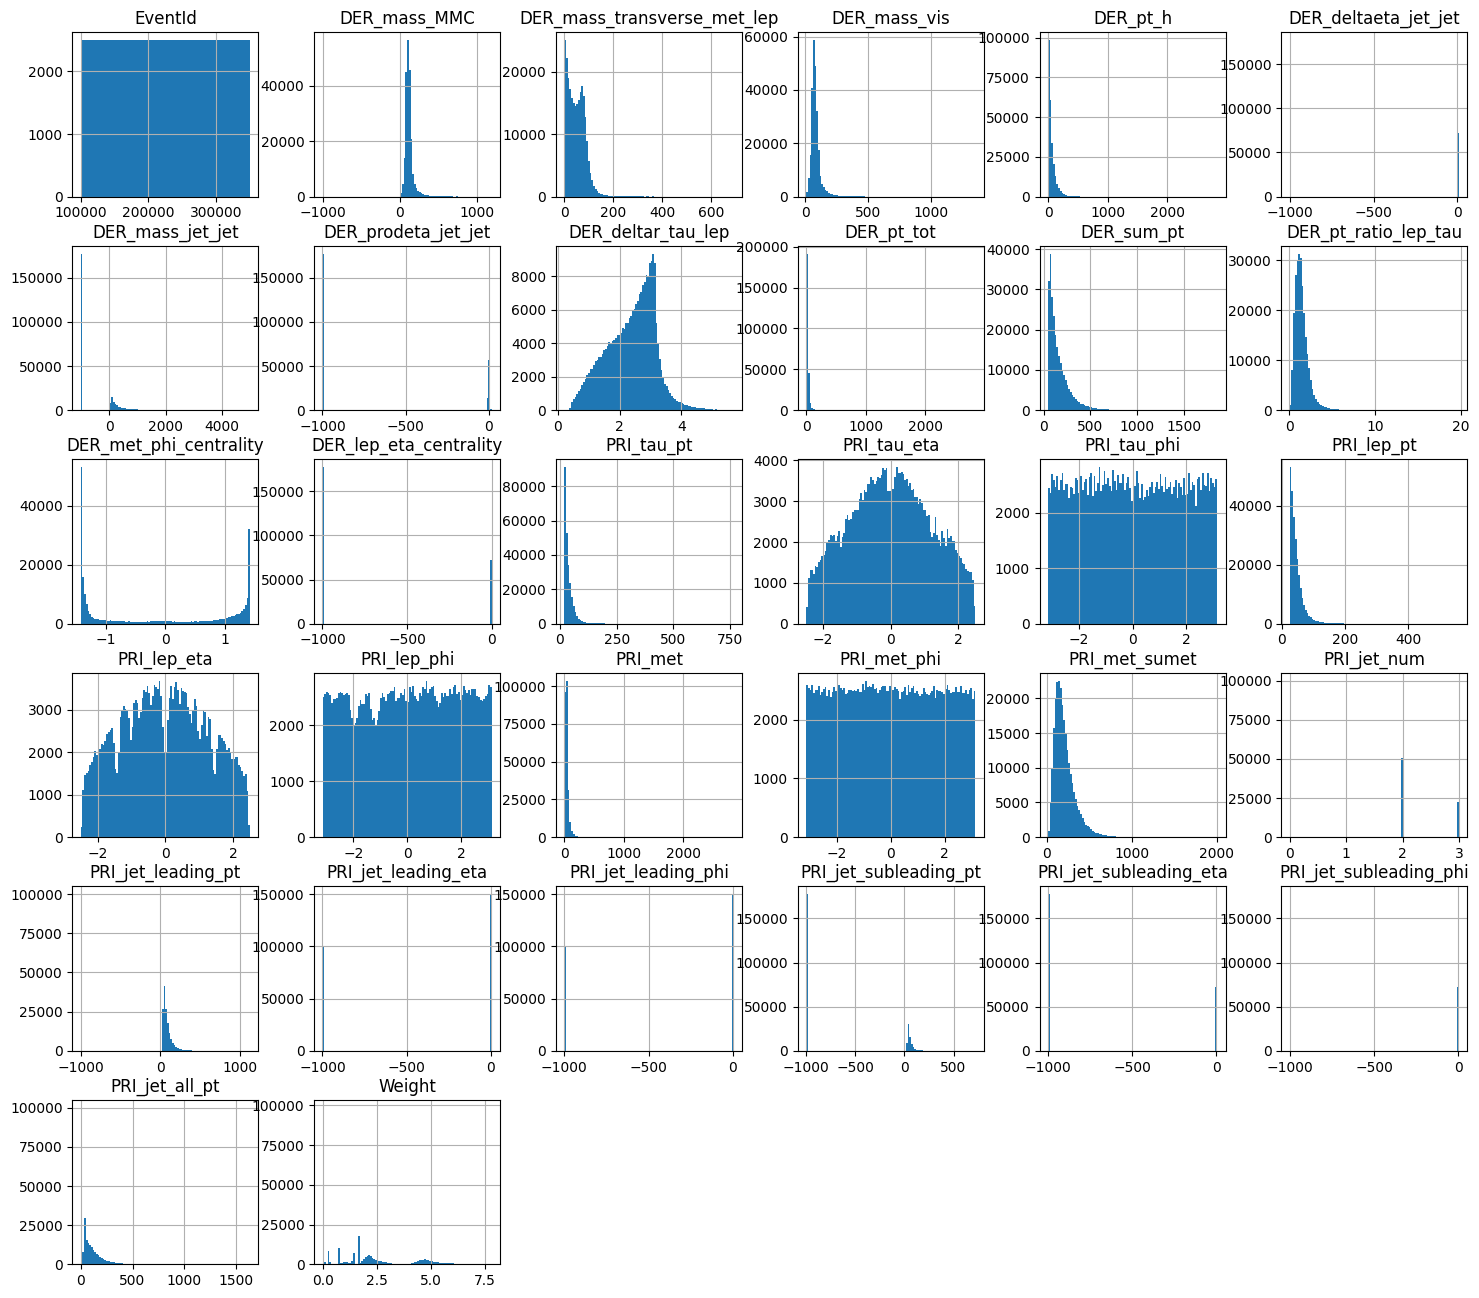

In [6]:
# the various variables of the data are visualized here
df_train.hist(bins=100, figsize=(18,16))
plt.show()

<Axes: >

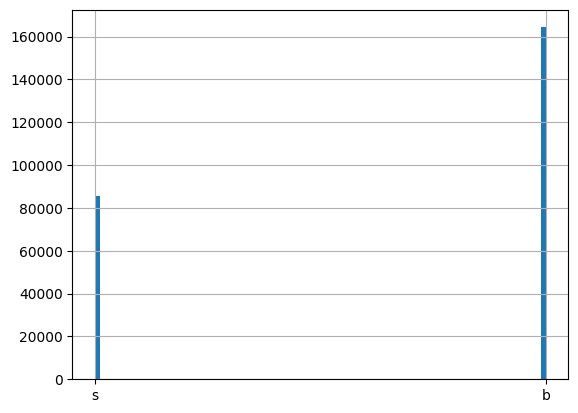

In [7]:
# the target variable for our ML algorithms is the label variable
df_train['Label'].hist(bins=100)

The labels show that there are two classes and they are imbalanced so let's try with the given classes ratio

The follwing code prepares the dataset by selecting specific feature variables, splitting it into training and testing sets while ensuring class balance, and encoding the target labels for machine learning. It's a common preprocessing step to set up data for model training and evaluation.

In [8]:
#the list var_train_test contains the variables which will be used for training and testing
var_train_test =['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

# the train_test_split will split the data into train and test sets while making sure that each one receives the same amount of signal and background
x_train, x_test, y_train, y_test = train_test_split(df_train[var_train_test].copy(), df_train['Label'], test_size=0.5, random_state=324, stratify=df_train['Label'])

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
dummy_y_train = tf.keras.utils.to_categorical(encoded_Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)
encoded_Y_test = encoder.transform(y_test)
dummy_y_test = tf.keras.utils.to_categorical(encoded_Y_test)

# Three different algorithms

This code is set up for hyperparameter optimization of different machine learning models, specifically Keras (MLP), XGBoost, and CNN. It defines custom callbacks and uses the Optuna library to find the best hyperparameters for each model type. The MyCustomCallback class helps free up memory during model training, which can be critical when working with deep learning models. The HP_OPT class provides a structured approach to hyperparameter tuning for various model types.

The Multi-layered perceptron will be used as the base model and XGBoost and Convolutional neural networs will be used as alternative models.

The MPL will use relu activation function at each layer except at the final layer which will be a softmax, because we want to create a classifier.

The hzperparameters optimization library Optuna is used here because it offers various HPO algorithms along with different prunning algorithms. It also offers parallel processing

In [9]:
#the following class will free up memory
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

class HP_OPT:
    def __init__(self, x_train, y_train, n_classes, batch_size, n_trials,
                 MLP_hyp_par, xgb_hyp_para, cnn_hyp_par=None):
        self.x_train = x_train
        self.y_train = y_train
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_trials = n_trials
        self.MLP_hyp_par = MLP_hyp_par
        self.xgb_hyp_para = xgb_hyp_para
        self.cnn_hyp_par = cnn_hyp_par
        self.X_train, self.X_valid, self.Y_train, self.Y_valid = train_test_split(
            x_train, y_train, test_size=0.2, random_state=324, stratify=y_train
        )
        self.epochs = 10
        self.input_shape = (self.X_train.shape[1], 1)

    # the method keras_objective will be used to find the HPs of the MLP. The HPs are the number of layers, the number of neurons and the learning rate
    def keras_objective(self, trial):
        # the trial suggest will choose the number of layers and the number of neurons
        n_layers = trial.suggest_int("n_layers", self.MLP_hyp_par['n_layers'][0], self.MLP_hyp_par['n_layers'][1])
        #the model is created here
        model = Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(self.X_train.shape[1],)))
        for i in range(n_layers):
            num_hidden = trial.suggest_int("n_units_l{}".format(i), self.MLP_hyp_par['n_units'][0], self.MLP_hyp_par['n_units'][1], log=True)
            model.add(tf.keras.layers.Dense(num_hidden, activation="relu"))
        # the softmax activation function is used at the end to convert the score between 0 and 1
        model.add(tf.keras.layers.Dense(self.n_classes, activation=tf.nn.softmax))

        #the learning rate is suggested here and is used in the compilation
        learning_rate = trial.suggest_float("learning_rate", self.MLP_hyp_par['learning_rate'][0], self.MLP_hyp_par['learning_rate'][1], log=True)
        model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=tf.keras.metrics.AUC(),
        )

        tf.keras.backend.clear_session()

        model.fit(self.X_train, self.Y_train, batch_size=self.batch_size,
            callbacks=[optuna.integration.TFKerasPruningCallback(trial, "val_auc"), MyCustomCallback()],
            epochs=self.epochs,
            validation_split=0.1,
            verbose=1
        )

        score = model.evaluate(self.X_valid, self.Y_valid, verbose=0)
        return score[1]

    def xgboost_objective(self, trial):
        param = {
            'booster': 'gbtree',
            "n_estimators": trial.suggest_int("n_estimators", self.xgb_hyp_para['n_estimators'][0], self.xgb_hyp_para['n_estimators'][1], step=10),
            "alpha": trial.suggest_int("alpha", self.xgb_hyp_para['alpha'][0], self.xgb_hyp_para['alpha'][1]),
            "gamma": trial.suggest_float("gamma", self.xgb_hyp_para['gamma'][0], self.xgb_hyp_para['gamma'][1]),
            "learning_rate": trial.suggest_float("learning_rate", self.xgb_hyp_para['learning_rate'][0], self.xgb_hyp_para['learning_rate'][1], log=True),
            "max_depth": trial.suggest_int("max_depth", self.xgb_hyp_para['max_depth'][0], self.xgb_hyp_para['max_depth'][1]),
            'objective': 'multi:softmax',
            'num_class': len(np.unique(self.y_train)),
        }

        clf = XGBClassifier(**param, tree_method='gpu_hist')
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        auc_scores = cross_val_score(clf, self.x_train, self.y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_mean = auc_scores.mean()

        trial.set_user_attr("n_estimators", clf.n_estimators)

        return auc_mean

    def cnn_objective(self, trial):
      scaler = StandardScaler()
      X_train = scaler.fit_transform(self.X_train)
      X_valid = scaler.transform(self.X_valid)
      #since the data is tabular and not image so we have to reshape it
      X_train = self.X_train.to_numpy().reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
      X_valid = self.X_valid.to_numpy().reshape(self.X_valid.shape[0], self.X_valid.shape[1], 1)

      clear_session()

      model = Sequential()
      model.add(
          Conv1D(
              filters=trial.suggest_categorical("filters", self.cnn_hyp_par['filters']),
              kernel_size=trial.suggest_categorical("kernel_size", self.cnn_hyp_par['kernel_size']),
              strides=trial.suggest_categorical("strides", self.cnn_hyp_par['strides']),
              activation="linear", input_shape=self.input_shape,
          )
      )

      n_conv_layers = trial.suggest_int("n_conv_layers", self.cnn_hyp_par['n_conv_layers_min'], self.cnn_hyp_par['n_conv_layers_max'])

      for i in range(n_conv_layers - 1):
          model.add(
              Conv1D(
                  filters=trial.suggest_categorical("filters", self.cnn_hyp_par['filters']),
                  kernel_size=trial.suggest_categorical("kernel_size", self.cnn_hyp_par['kernel_size']),
                  strides=trial.suggest_categorical("strides", self.cnn_hyp_par['strides']),
                  activation="linear",
              )
          )
          dropout_rate = trial.suggest_float("conv_dropout_rate_l{}".format(i), self.cnn_hyp_par['dropout_min'], self.cnn_hyp_par['dropout_max'])
          model.add(Dropout(dropout_rate))

      model.add(Flatten())

      n_layers = trial.suggest_int("n_layers", self.cnn_hyp_par['n_layers_min'], self.cnn_hyp_par['n_layers_max'])
      for i in range(n_layers):
          num_hidden = trial.suggest_int("n_units_l{}".format(i), self.cnn_hyp_par['n_units_min'], self.cnn_hyp_par['n_units_max'], log=True)
          model.add(Dense(num_hidden, activation="relu", activity_regularizer=l1(0.001)))
          dropout_rate = trial.suggest_float("dropout_rate_l{}".format(i), self.cnn_hyp_par['dropout_min'], self.cnn_hyp_par['dropout_max'])
          model.add(Dropout(dropout_rate))
          model.add(BatchNormalization())

      model.add(Dense(self.n_classes, activation="softmax"))

      learning_rate = trial.suggest_float("learning_rate", self.cnn_hyp_par['learning_rate_min'], self.cnn_hyp_par['learning_rate_max'], log=True)
      model.compile(
          loss="sparse_categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Use tf.keras.optimizers
          metrics=["accuracy"],
      )

      early_stop = EarlyStopping(monitor='val_loss', patience=3)
      reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

      model.fit(
          X_train, self.Y_train, validation_data=(X_valid, self.Y_valid),
          shuffle=True, batch_size=self.batch_size,
          epochs=self.epochs, verbose=False, callbacks=[early_stop, reduce_lr]
      )

      score = model.evaluate(X_valid, self.Y_valid, verbose=0)
      print(f"Trial {trial.number}, Score: {score[1]}")
      print(f"Parameters: {trial.params}")

      return score[1]

    def optimize(self, model_type):
      # from optuna we will use the TPE algorithm to find the best HPs and we will use the prunning algorithm SuccessiveHalvingPruner
        study = optuna.create_study(direction="maximize", pruner=optuna.pruners.SuccessiveHalvingPruner(), sampler=optuna.samplers.TPESampler())

        if model_type == "keras":
            study.optimize(self.keras_objective, n_trials=self.n_trials, gc_after_trial=True)
            print("Keras Best Trial:")
        elif model_type == "xgboost":
            study.optimize(self.xgboost_objective, n_trials=self.n_trials, gc_after_trial=True)
            print("XGBoost Best Trial:")
        elif model_type == "cnn":
            study.optimize(self.cnn_objective, n_trials=self.n_trials, gc_after_trial=True)
            print("CNN Best Trial:")
        else:
            raise ValueError("Invalid model_type. Choose 'keras', 'xgboost', or 'cnn'.")

        return study

Let's optimze  hyperparamters! The following script
 for optimizing hyperparameters of machine learning models, specifically Keras, XGBoost, and CNN, for a given dataset

In [10]:

if __name__ == "__main__":
    # Load your dataset and labels here
    BATCHSIZE = 4096

    # Define hyperparameter ranges or choices for Keras, XGBoost, and CNN
    keras_hyperparameters = {
        'n_layers': (2, 22),
        'n_units': (2500, 4500),
        'learning_rate': (1e-5, 1e-1)
        # Add more Keras hyperparameters here as needed
    }

    xgboost_hyperparameters = {
        'n_estimators': (100, 1000),
        'alpha': (2, 30),
        'gamma': (0, 1),
        'learning_rate': (0.01, 1),
        'max_depth': (0, 10)
        # Add more XGBoost hyperparameters here as needed
    }

    cnn_hyperparameters = {
        'filters': [32, 64],
        'kernel_size': [3, 5],
        'strides': [1, 2],
        'n_conv_layers_min': 0,
        'n_conv_layers_max': 3,
        'dropout_min': 0.0,
        'dropout_max': 0.5,
        'n_layers_min': 2,
        'n_layers_max': 22,
        'n_units_min': 1000,
        'n_units_max': 1500,
        'learning_rate_min': 1e-5,
        'learning_rate_max': 1e-1
        # Define CNN hyperparameters here
    }

    optimizer = HP_OPT(x_train, dummy_y_train, len(np.unique(y_train)), BATCHSIZE, 10,
                                        keras_hyperparameters, xgboost_hyperparameters, cnn_hyperparameters)

    # Optimize the Keras model
    study_keras = optimizer.optimize("keras")

    # Optimize the XGBoost model
    #study_xgboost = optimizer.optimize("xgboost")

    # Optimize the CNN model
    #study_cnn = optimizer.optimize("cnn")

[I 2023-10-26 18:57:29,312] A new study created in memory with name: no-name-bd7373c9-f7f2-4a2b-a26c-42fd2ab801b2


Epoch 1/10
 6/22 [=======>......................] - ETA: 2s - loss: 140.3613 - auc: 0.6205

22/22 [==============================] - 11s 196ms/step - loss: 50.4867 - auc: 0.6067 - val_loss: 6.5046 - val_auc: 0.7019
Epoch 2/10
22/22 [==============================] - 4s 185ms/step - loss: 3.5163 - auc: 0.6555 - val_loss: 5.4396 - val_auc: 0.5787
Epoch 3/10
22/22 [==============================] - 4s 183ms/step - loss: 2.3457 - auc: 0.6680 - val_loss: 0.9848 - val_auc: 0.7911
Epoch 4/10
22/22 [==============================] - 4s 184ms/step - loss: 1.3917 - auc: 0.7077 - val_loss: 3.1947 - val_auc: 0.4868
Epoch 5/10
22/22 [==============================] - 4s 192ms/step - loss: 2.5640 - auc: 0.6647 - val_loss: 2.1492 - val_auc: 0.4691
Epoch 6/10
22/22 [==============================] - 4s 186ms/step - loss: 0.7811 - auc: 0.7590 - val_loss: 0.5571 - val_auc: 0.8357
Epoch 7/10
22/22 [==============================] - 4s 187ms/step - loss: 0.5463 - auc: 0.8207 - val_loss: 1.0761 - val_auc: 0.5719
Epoch 8/10
22/22 [==============================] - 4s 195ms/step - loss: 0.7225 - au

[I 2023-10-26 18:58:57,396] Trial 0 finished with value: 0.853793203830719 and parameters: {'n_layers': 3, 'n_units_l0': 2883, 'n_units_l1': 3703, 'n_units_l2': 3971, 'learning_rate': 0.00015012805897549202}. Best is trial 0 with value: 0.853793203830719.


Epoch 1/10
 6/22 [=======>......................] - ETA: 23s - loss: 405514034872320.0000 - auc: 0.4793

22/22 [==============================] - 42s 2s/step - loss: 110799645310976.0000 - auc: 0.5089 - val_loss: 2996886528.0000 - val_auc: 0.6669
Epoch 2/10
22/22 [==============================] - 36s 2s/step - loss: 7817177600.0000 - auc: 0.5269 - val_loss: 135876896.0000 - val_auc: 0.3331
Epoch 3/10
22/22 [==============================] - 34s 2s/step - loss: 671148480.0000 - auc: 0.5160 - val_loss: 1261175.2500 - val_auc: 0.6669
Epoch 4/10
22/22 [==============================] - 34s 2s/step - loss: 1097631.7500 - auc: 0.5296 - val_loss: 68796.8281 - val_auc: 0.3331
Epoch 5/10
22/22 [==============================] - 35s 2s/step - loss: 17860.3652 - auc: 0.5295 - val_loss: 375680.0312 - val_auc: 0.3331
Epoch 6/10
22/22 [==============================] - 35s 2s/step - loss: 744035.4375 - auc: 0.5596 - val_loss: 131365.2812 - val_auc: 0.3331
Epoch 7/10
22/22 [==============================] - 34s 2s/step - loss: 683862.8750 - auc: 0.4781 - val_loss: 44926432.0000 - val_auc: 0.6669
Epoch 

[I 2023-10-26 19:05:28,914] Trial 1 finished with value: 0.6573200225830078 and parameters: {'n_layers': 22, 'n_units_l0': 2708, 'n_units_l1': 3852, 'n_units_l2': 2786, 'n_units_l3': 3427, 'n_units_l4': 3446, 'n_units_l5': 4304, 'n_units_l6': 2966, 'n_units_l7': 3879, 'n_units_l8': 4437, 'n_units_l9': 2995, 'n_units_l10': 3936, 'n_units_l11': 3217, 'n_units_l12': 4197, 'n_units_l13': 2707, 'n_units_l14': 2883, 'n_units_l15': 2982, 'n_units_l16': 3388, 'n_units_l17': 3097, 'n_units_l18': 3585, 'n_units_l19': 2654, 'n_units_l20': 2520, 'n_units_l21': 4161, 'learning_rate': 0.0044080923388569206}. Best is trial 0 with value: 0.853793203830719.


Epoch 1/10
 6/22 [=======>......................] - ETA: 10s - loss: 12.3021 - auc: 0.5740

22/22 [==============================] - 19s 685ms/step - loss: 4.3577 - auc: 0.6121 - val_loss: 0.6485 - val_auc: 0.6432
Epoch 2/10
22/22 [==============================] - 15s 681ms/step - loss: 0.5791 - auc: 0.7587 - val_loss: 0.5568 - val_auc: 0.8044
Epoch 3/10
22/22 [==============================] - 14s 655ms/step - loss: 0.5447 - auc: 0.7958 - val_loss: 0.5379 - val_auc: 0.8085
Epoch 4/10
22/22 [==============================] - 14s 645ms/step - loss: 0.5278 - auc: 0.8109 - val_loss: 0.5171 - val_auc: 0.8285
Epoch 5/10
22/22 [==============================] - 14s 643ms/step - loss: 0.5209 - auc: 0.8153 - val_loss: 0.5029 - val_auc: 0.8350
Epoch 6/10
22/22 [==============================] - 14s 646ms/step - loss: 0.5183 - auc: 0.8179 - val_loss: 0.4903 - val_auc: 0.8428
Epoch 7/10
22/22 [==============================] - 14s 652ms/step - loss: 0.5304 - auc: 0.8127 - val_loss: 0.5474 - val_auc: 0.8310
Epoch 8/10
22/22 [==============================] - 14s 650ms/step - loss: 0.512

[I 2023-10-26 19:08:58,605] Trial 2 finished with value: 0.8544376492500305 and parameters: {'n_layers': 9, 'n_units_l0': 3400, 'n_units_l1': 2924, 'n_units_l2': 2541, 'n_units_l3': 3562, 'n_units_l4': 3244, 'n_units_l5': 3772, 'n_units_l6': 3161, 'n_units_l7': 3643, 'n_units_l8': 4123, 'learning_rate': 0.00010404158353599307}. Best is trial 2 with value: 0.8544376492500305.


Epoch 1/10
 6/22 [=======>......................] - ETA: 2s - loss: 32.3577 - auc: 0.6248

22/22 [==============================] - 6s 158ms/step - loss: 13.8616 - auc: 0.6313 - val_loss: 7.3523 - val_auc: 0.6967
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 5.4605 - auc: 0.6577

[I 2023-10-26 19:09:07,552] Trial 3 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/22 [=======>......................] - ETA: 16s - loss: nan - auc: 0.5062

22/22 [==============================] - 30s 1s/step - loss: nan - auc: 0.5014 - val_loss: nan - val_auc: 0.5000
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: nan - auc: 0.5000

[I 2023-10-26 19:09:59,143] Trial 4 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/22 [=======>......................] - ETA: 2s - loss: 117.4619 - auc: 0.5437

22/22 [==============================] - 5s 166ms/step - loss: 51.8448 - auc: 0.5877 - val_loss: 21.7962 - val_auc: 0.4200
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 8.8990 - auc: 0.6290

[I 2023-10-26 19:10:07,491] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/22 [=======>......................] - ETA: 16s - loss: 11264.6963 - auc: 0.5444

22/22 [==============================] - 29s 1s/step - loss: 3096.3254 - auc: 0.5248 - val_loss: 10.7828 - val_auc: 0.6653
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 3.3842 - auc: 0.5960

[I 2023-10-26 19:11:04,653] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/22 [=======>......................] - ETA: 7s - loss: 23188179061284274176.0000 - auc: 0.5122

22/22 [==============================] - 15s 503ms/step - loss: 6331952774187581440.0000 - auc: 0.5291 - val_loss: 3789406339072.0000 - val_auc: 0.6669
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 15638694199296.0000 - auc: 0.5337

[I 2023-10-26 19:11:30,952] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/22 [=======>......................] - ETA: 19s - loss: 1.0726 - auc: 0.6385

22/22 [==============================] - 35s 1s/step - loss: 0.7264 - auc: 0.7134 - val_loss: 0.5871 - val_auc: 0.7657
Epoch 2/10
22/22 [==============================] - 29s 1s/step - loss: 0.5689 - auc: 0.7675 - val_loss: 0.5702 - val_auc: 0.7775
Epoch 3/10
22/22 [==============================] - 28s 1s/step - loss: 0.5614 - auc: 0.7756 - val_loss: 0.5575 - val_auc: 0.7845
Epoch 4/10
22/22 [==============================] - 28s 1s/step - loss: 0.5542 - auc: 0.7853 - val_loss: 0.5513 - val_auc: 0.8019
Epoch 5/10
22/22 [==============================] - ETA: 0s - loss: 0.5565 - auc: 0.7840

[I 2023-10-26 19:14:16,216] Trial 8 pruned. Trial was pruned at epoch 4.


Epoch 1/10
 6/22 [=======>......................] - ETA: 4s - loss: 200.0335 - auc: 0.4963

22/22 [==============================] - 9s 335ms/step - loss: 64.0644 - auc: 0.5814 - val_loss: 2.3521 - val_auc: 0.5366
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 1.2493 - auc: 0.6618

[I 2023-10-26 19:15:28,017] Trial 9 pruned. Trial was pruned at epoch 1.


Keras Best Trial:


##Hyperparameters optimization
The [Optuna](https://optuna.org/) library is used to optimize the hyper-parameters with its inbuilt TPE algorithm. The library's optimize function calls NUMBER_TRIALS number of trials. Each trial has EPOCHS number of epochs.

### Neural networks HP optimization
The number of layers, number of neurons and the learning rate will be searched

In [21]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study_keras)

 **The BEST of ALL!!-** The following code segment creates a machine learning model with a customized architecture based on the best hyperparameters obtained through hyperparameter optimization. It defines the model's layers, activation functions, optimizer, loss function, and evaluation metrics. The model summary is printed to provide an overview of its architecture and configuration.

In [24]:
# Use the best hyperparameters found by the Optuna package to define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)))
for i in range(0,len(study_keras.best_trial.params)-2):
    model.add(tf.keras.layers.Dense(study_keras.best_trial.params["n_units_l"+str(i)], activation='relu'))
model.add(tf.keras.layers.Dense(len(np.unique(y_test)), activation=tf.nn.softmax))

from tensorflow.keras.losses import SparseCategoricalCrossentropy
adam = tf.keras.optimizers.Adam(learning_rate=study_keras.best_trial.params["learning_rate"])
model.compile(optimizer=adam,  loss=tf.keras.losses.CategoricalCrossentropy(),  metrics=[
         tf.keras.metrics.CategoricalAccuracy(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall(),
         tf.keras.metrics.AUC()
       ])

print(model.summary())

ResourceExhaustedError: ignored

In [18]:
# Train the model for 50 epochs
history = model.fit(x_train, dummy_y,validation_split = 0.1, epochs=50, batch_size=BATCHSIZE)

RuntimeError: ignored

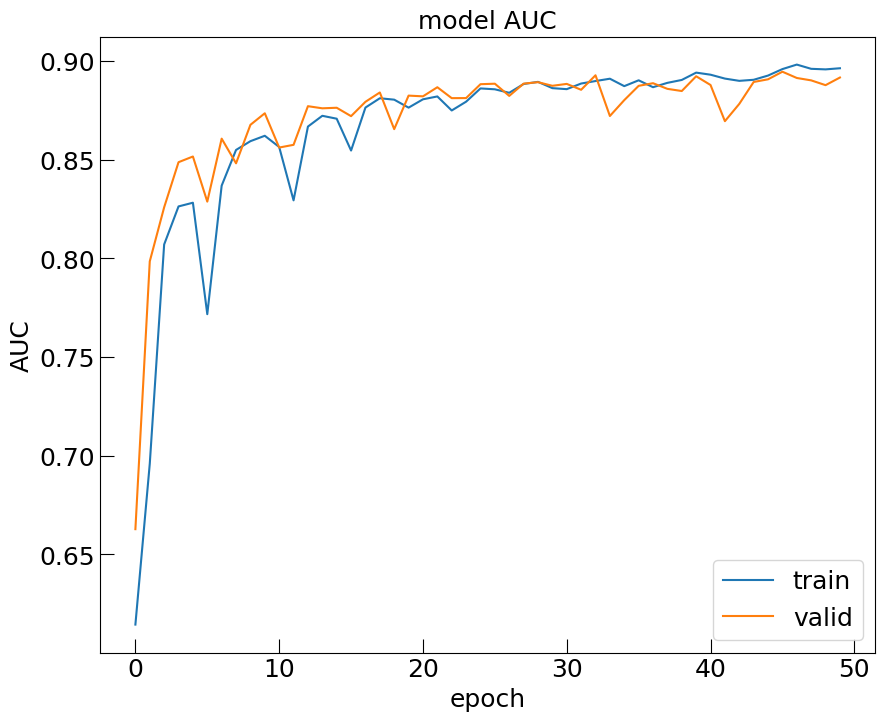

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='valid')
plt.title('model AUC', fontsize =18)
plt.ylabel('AUC', fontsize =18)
plt.xlabel('epoch', fontsize =18)
plt.legend(loc="lower right",fontsize =18)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)

In [ ]:
with tf.device('/device:GPU:0'):
    predictions_test_numpy = model.predict(x_test)

3907/3907 [==============================] - 10s 2ms/step



This function is to visualize the ROC curves and AUC values for a binary classification model. It will display a plot with one ROC curve per class, each with a different linestyle and linewidth, and it will label each curve with its AUC value.

the ROC curve is a visual tool that shows how well a classification model performs at different probability thresholds, and the AUC is a quantitative measure that summarizes the model's performance into a single number. These metrics are commonly used in the evaluation and comparison of binary classification models, helping to assess their ability to distinguish between positive and negative instances

In [9]:
from sklearn.metrics import roc_curve, auc

n_classes = len(np.unique(y_test))
alphas = [0.9, 0.8] * 7
linestyles = ['-.', '-'] * 7
linewidthss = [2, 1] * 7

def plot_roc_curves(dummy_y_test, predictions_test_numpy, n_classes, linestyles, linewidthss, label_for_auc):
    roc_data = {}
    fig, ax = plt.subplots(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(dummy_y_test[:, i], predictions_test_numpy[:, i], drop_intermediate=False)
        roc_auc = auc(fpr, tpr)
        roc_data[i] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
        plt.plot(fpr, tpr, linestyle=linestyles[i], linewidth=linewidthss[i], label=f"({label_for_auc} AUC = {roc_auc:0.3f} for class {i}")

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
    plt.title("ROC curve", fontsize=16)
    plt.legend(loc='lower right', fontsize=16)
    ax.tick_params(axis='both', which='major', length=10, direction='in', labelsize=18, zorder=4)
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)

    plt.show()
    return roc_data

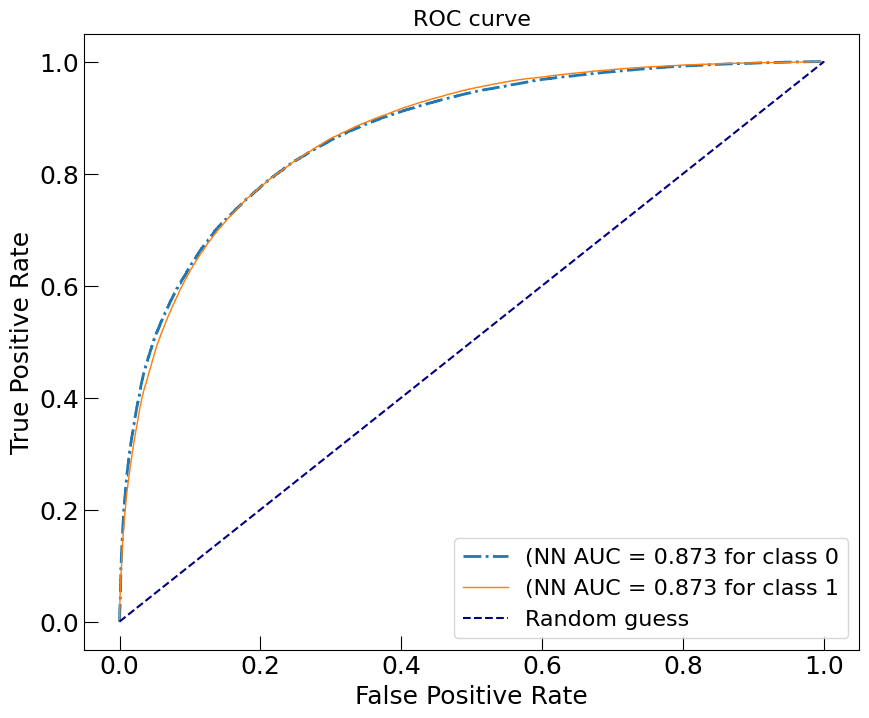

In [ ]:
roc_data = plot_roc_curves(dummy_y_test, predictions_test_numpy, n_classes, linestyles, linewidthss, 'MLP')

The Shapley method is a game theory concept that's been adapted for machine learning model interpretation. It provides a way to fairly distribute the "credit" or "blame" for a particular prediction among the model's input features.
In the context of machine learning, it helps to understand how each feature contributes to a specific prediction.

In [12]:
#The shapley method from the SHAP library will be used to understand the behavior of the model
explainer = shap.KernelExplainer(model, x_train.iloc[:50,:])
shap_values = explainer.shap_values(x_train.iloc[200:600,:], nsamples=500)

NameError: ignored

this code creates a customized summary plot using SHAP to visualize the feature contributions (Shapley values) for a specific subset of data points. The plot is larger than the default size, and the aspect ratio is adjusted for clarity. The use of SHAP summary plots helps in interpreting the impact of different features on the model's predictions for the selected data instances.

NameError: ignored

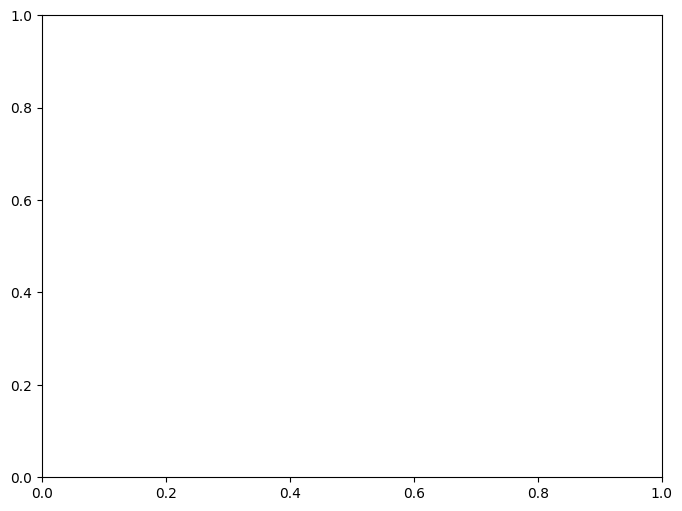

In [13]:
fig, ax= plt.subplots(figsize=(8,6))
shap.summary_plot(shap_values, x_train.iloc[280:330,:], plot_size=[18,10],color=plt.get_cmap("tab10"), show=False)
w, h = plt.gcf().get_size_inches()
plt.gcf().axes[-1].set_aspect('auto')
fig.tight_layout()

The shap summary plot shows that the PRI_jet_leading_pt is the most useful variable for the separation of the two classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

path = "/content/drive/MyDrive/HiggsChallenge"
os.mkdir(path)

In [ ]:
model.save("/content/drive/MyDrive/HiggsChallenge/deep_model.keras")

## XGBoost

In [ ]:
y_train_new = y_train.replace('s', 1, regex=True)
y_train_new = y_train_new.replace('b', 0, regex=True)


if __name__ == "__main__":
    # Load your dataset and labels here
    BATCHSIZE = 4096

    # Define hyperparameter ranges or choices for Keras, XGBoost, and CNN
    keras_hyperparameters = {
        'n_layers': (2, 22),
        'n_units': (2500, 4500),
        'learning_rate': (1e-5, 1e-1)
        # Add more Keras hyperparameters here as needed
    }

    xgboost_hyperparameters = {
        'n_estimators': (100, 1000),
        'alpha': (2, 30),
        'gamma': (0, 1),
        'learning_rate': (0.01, 1),
        'max_depth': (0, 10)
        # Add more XGBoost hyperparameters here as needed
    }

    cnn_hyperparameters = {
        'filters': [32, 64],
        'kernel_size': [3, 5],
        'strides': [1, 2],
        'n_conv_layers_min': 0,
        'n_conv_layers_max': 3,
        'dropout_min': 0.0,
        'dropout_max': 0.5,
        'n_layers_min': 2,
        'n_layers_max': 22,
        'n_units_min': 1000,
        'n_units_max': 1500,
        'learning_rate_min': 1e-5,
        'learning_rate_max': 1e-1
        # Define CNN hyperparameters here
    }

    optimizer = HP_OPT_class_code.HP_OPT(x_train, y_train_new, len(np.unique(y_train)), BATCHSIZE, 10,
                                        keras_hyperparameters, xgboost_hyperparameters, cnn_hyperparameters)
    study_xgboost = optimizer.optimize("xgboost")


[I 2023-10-20 13:58:05,904] A new study created in memory with name: no-name-d4abf053-4909-4372-8355-c563cd466e5f
[I 2023-10-20 13:58:13,365] Trial 0 finished with value: 0.9057982255946841 and parameters: {'n_estimators': 340, 'alpha': 20, 'gamma': 0.8676275997696594, 'learning_rate': 0.44432848993099416, 'max_depth': 5}. Best is trial 0 with value: 0.9057982255946841.
[I 2023-10-20 13:58:17,424] Trial 1 finished with value: 0.9074940730002425 and parameters: {'n_estimators': 100, 'alpha': 18, 'gamma': 0.608453951022297, 'learning_rate': 0.26872409814022197, 'max_depth': 7}. Best is trial 1 with value: 0.9074940730002425.
[I 2023-10-20 13:58:20,339] Trial 2 finished with value: 0.8855393036690599 and parameters: {'n_estimators': 160, 'alpha': 20, 'gamma': 0.6629447337576005, 'learning_rate': 0.802232003302305, 'max_depth': 1}. Best is trial 1 with value: 0.9074940730002425.
[I 2023-10-20 13:58:29,281] Trial 3 finished with value: 0.8972859204128513 and parameters: {'n_estimators': 220

XGBoost Best Trial:


In [ ]:
figure = plot_optimization_history(study_xgboost)
newnames = {'Objective Value':'TPE Objective', 'Best Value': 'TPE Best'} # From the other post
figure.update_traces(marker=dict(color="RoyalBlue",opacity=0.5,symbol=100), line=dict(dash='dash'))
figure.update_layout(
    title={
        'text': "",
        'y':0.85,
        'x':0.5,
        'yanchor': 'top'},
    legend=dict(
    yanchor="top",
    y=0.3,
    xanchor="left",
    x=0.6
),yaxis_range=[0.9,1.001],
    xaxis_title={'text':"Trial",'standoff':0.01,},
    yaxis_title={'text':"mean AUC (test)",'standoff':0.01,},
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
figure.update_traces(marker=dict(color="Blue",size=10, symbol=200), line=dict(dash='dot', width=4))



In [ ]:
param= {'alpha': study_xgboost.best_params["alpha"], 'gamma': study_xgboost.best_params["gamma"],
        'learning_rate': study_xgboost.best_params["learning_rate"],
        'max_depth': int(round(study_xgboost.best_params["max_depth"],0)),
        'n_estimators': int(round(study_xgboost.best_params["n_estimators"],0)), 'num_class':2,'objective':'multi:softmax',
        'subsample': 0.8,'eval_metric': 'auc','tree_method':'hist', 'device':'cuda'}

import xgboost as xgb
#Fit/train on training data
xgb_clf = xgb.XGBClassifier(**param)
xgb_clf.fit(x_train,y_train_new)

XGBClassifier(alpha=21, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.07709733373894412, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0848734006222281,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=740, n_jobs=None, num_class=2, ...)

In [ ]:
predictions=xgb_clf.predict_proba(x_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:59:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




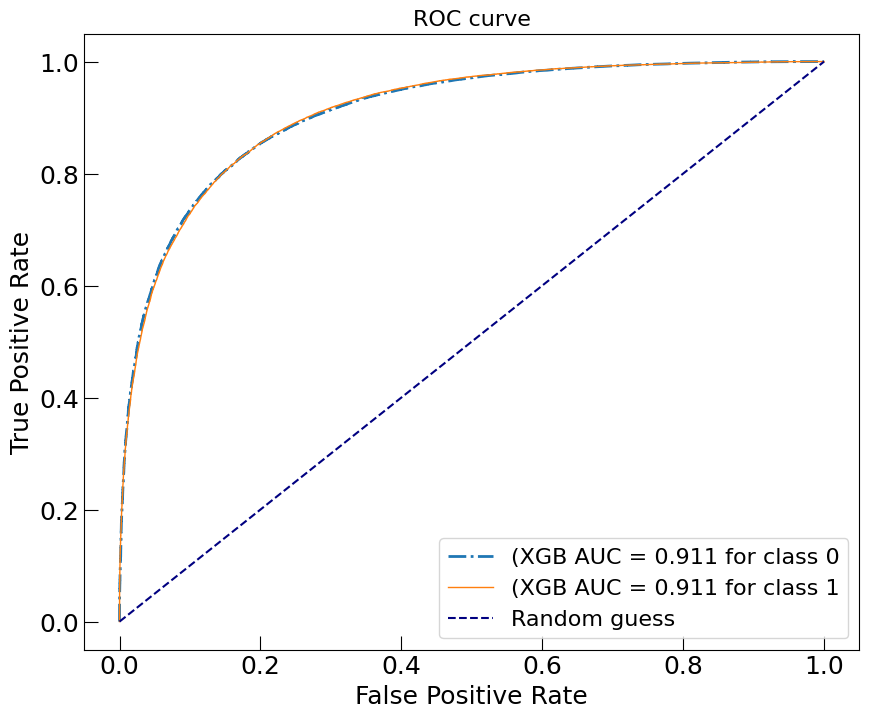

In [ ]:
roc_data_xgb = plot_roc_curves(dummy_y_test, predictions, n_classes, linestyles, linewidthss, 'XGB')

In [ ]:
x_train_small = x_train.sample(n=1000)
import time

start = time.time()
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(x_train_small)
end = time.time()
print(end - start)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[13:59:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



3.8118908405303955


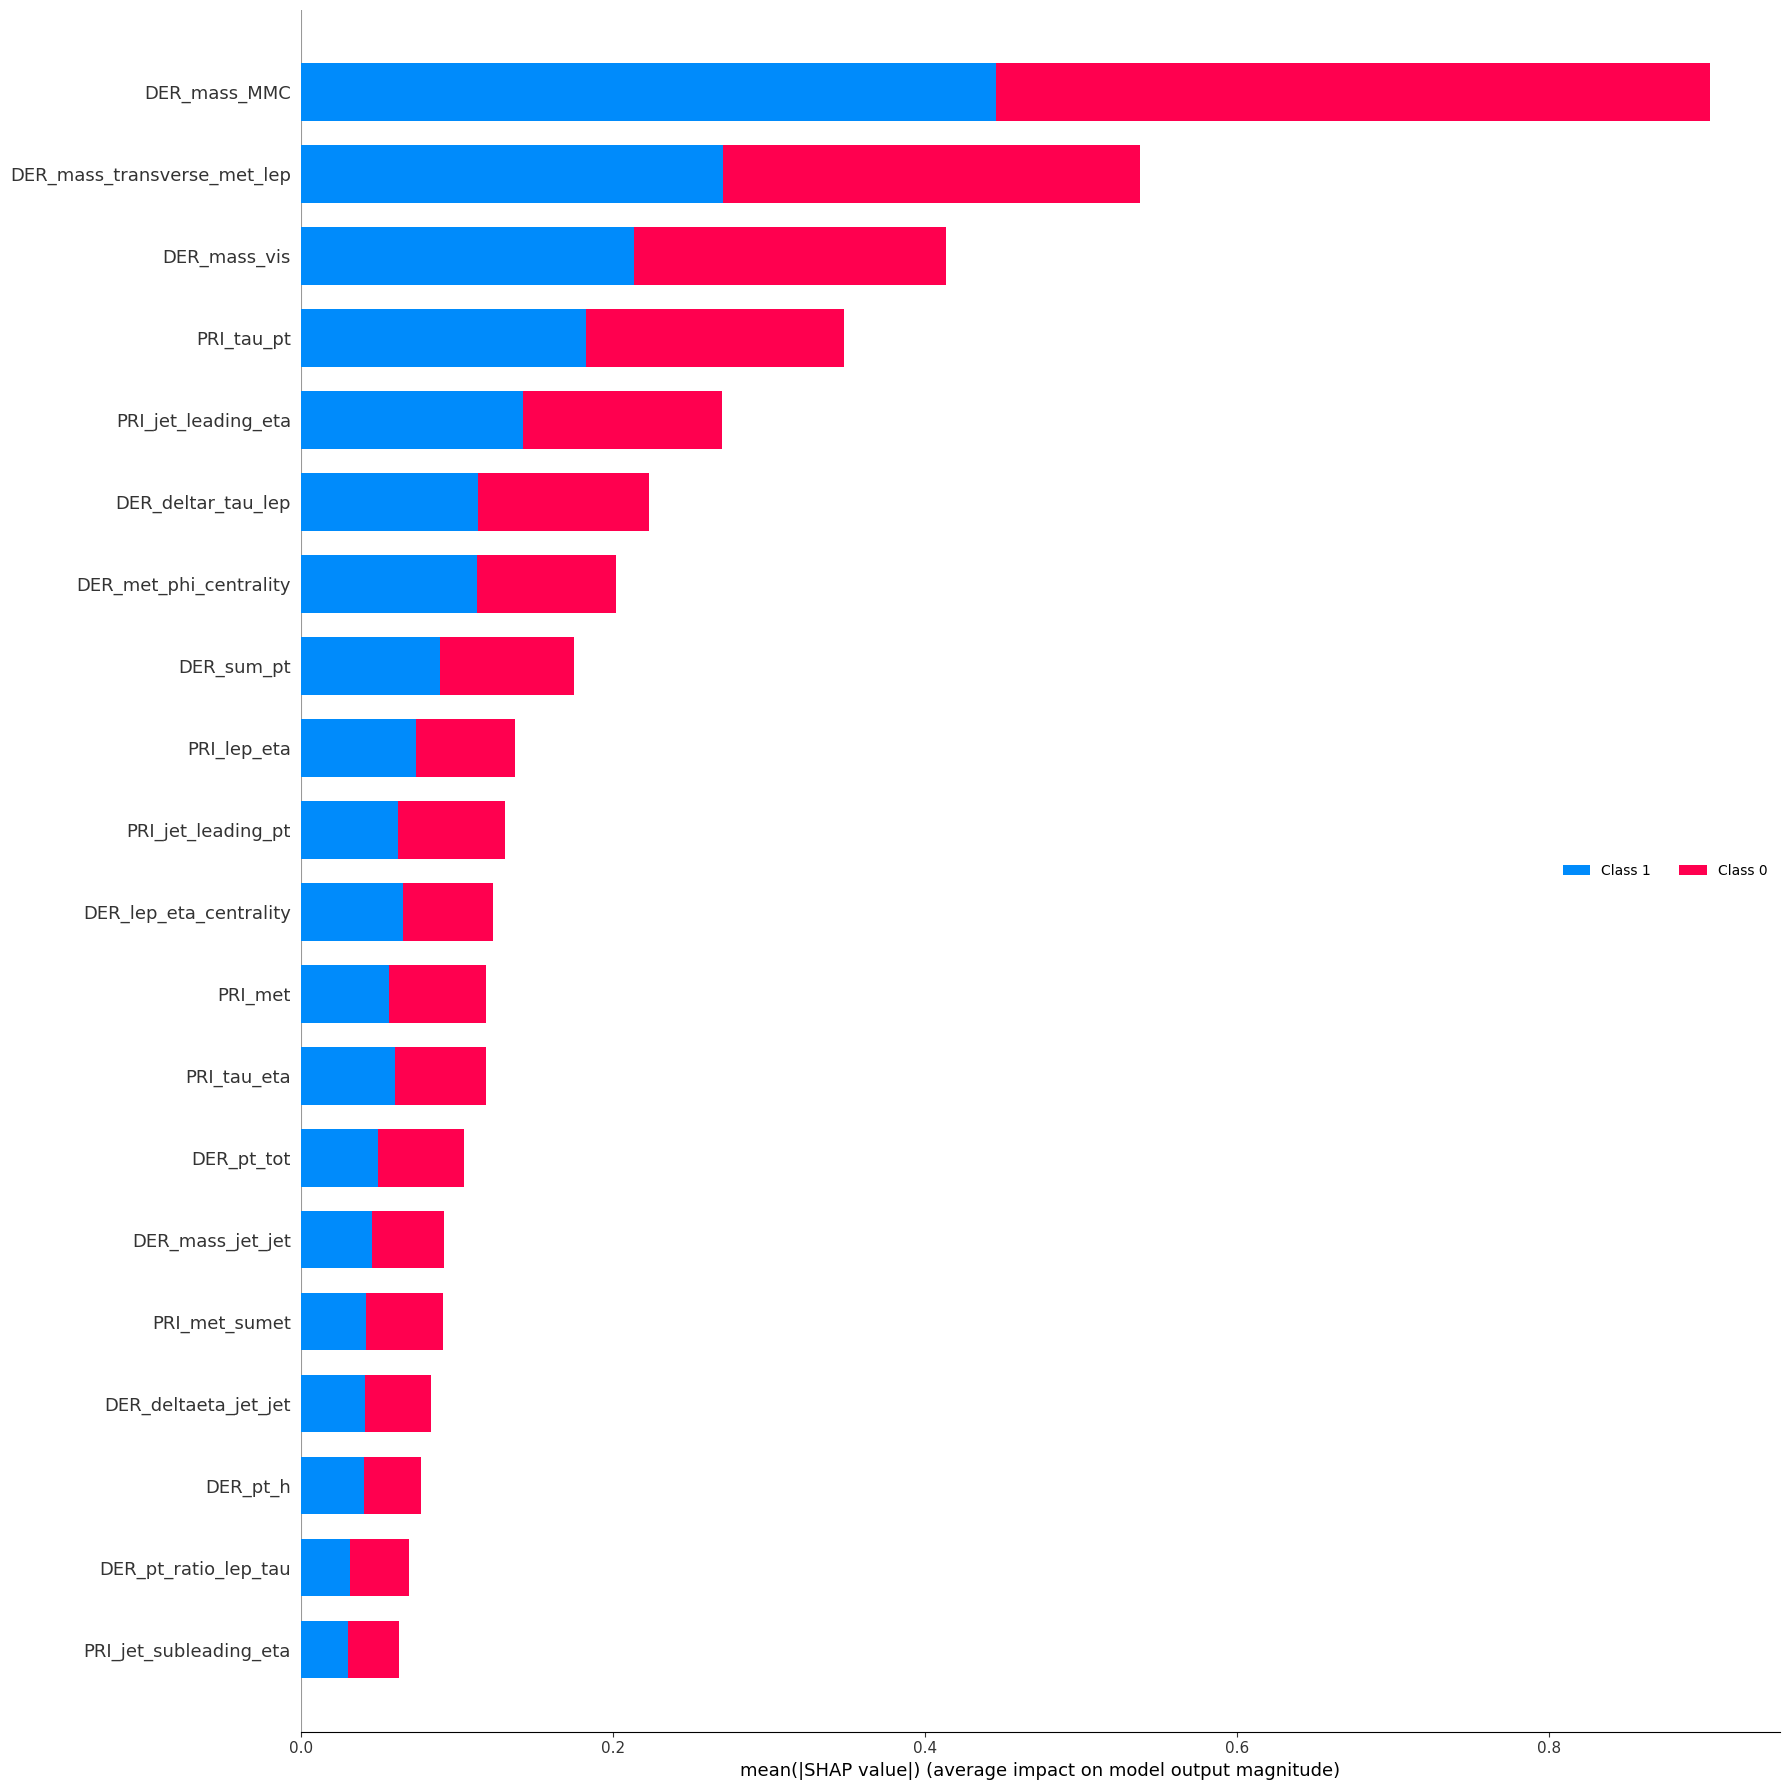

In [ ]:
from matplotlib.colors import ListedColormap
fig, ax= plt.subplots(figsize=(18,18))
shap.summary_plot(shap_values, x_train_small,plot_size=[18,18], show=False)

w, h = plt.gcf().get_size_inches()
plt.gcf().axes[-1].set_aspect('auto')
plt.legend(loc='center right',ncol=2, frameon=False, fontsize=10)
fig.tight_layout()

In [ ]:
xgb_clf.save_model('/content/drive/MyDrive/HiggsChallenge/xgb.model')

## Comparison between NN and XGB

Text(0, 0.5, 'True Positive Rate')

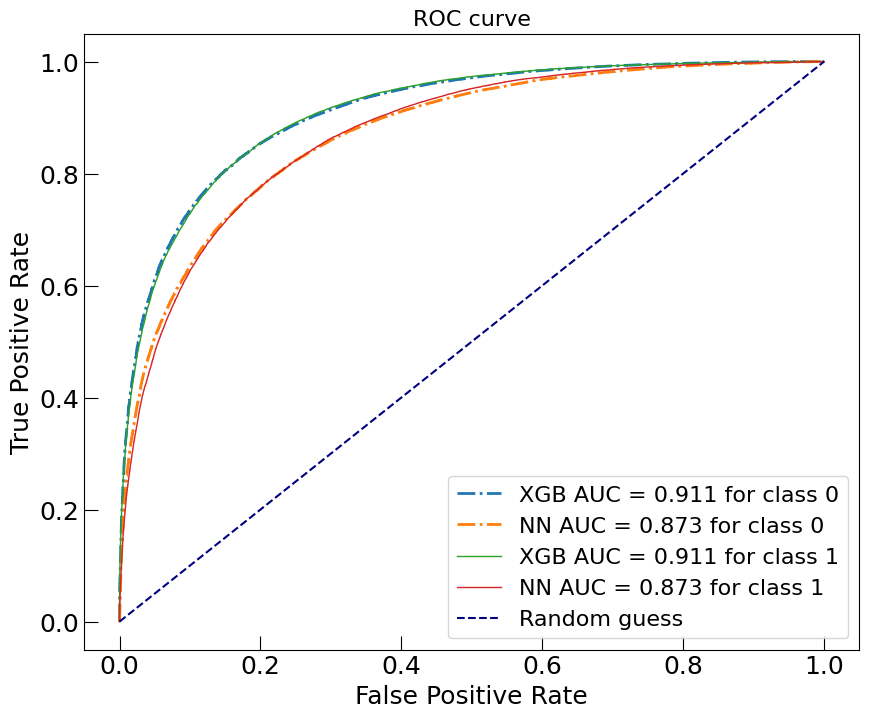

In [ ]:
fig, ax =plt.subplots(figsize=(10,8))
for i in range(n_classes):
    plt.plot(roc_data_xgb[i]['fpr'],roc_data_xgb[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"XGB AUC = {roc_data_xgb[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data[i]['fpr'], roc_data[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"NN AUC = {roc_data[i]['roc_auc']:0.3f} for class {i}")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
plt.title("ROC curve", fontsize=16)
plt.legend(loc='lower right',fontsize=16)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)
plt.xlabel("False Positive Rate",fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)

In [ ]:
x_unseen = df_test[var_train_test].copy()

with tf.device('/device:GPU:0'):
    predictions_test_numpy = model.predict(x_unseen)

17188/17188 [==============================] - 41s 2ms/step


## CNN

In [ ]:
y_train_new = y_train.replace('s', 1, regex=True)
y_train_new = y_train_new.replace('b', 0, regex=True)
if __name__ == "__main__":
    # Load your dataset and labels here
    BATCHSIZE = 4096

    # Define hyperparameter ranges or choices for Keras, XGBoost, and CNN
    keras_hyperparameters = {
        'n_layers': (2, 22),
        'n_units': (2500, 4500),
        'learning_rate': (1e-5, 1e-1)
    }

    xgboost_hyperparameters = {
        'n_estimators': (100, 1000),
        'alpha': (2, 30),
        'gamma': (0, 1),
        'learning_rate': (0.01, 1),
        'max_depth': (0, 10)
    }

    cnn_hyperparameters = {
        'filters': [32, 64],
        'kernel_size': [3, 5],
        'strides': [1, 2],
        'n_conv_layers_min': 0,
        'n_conv_layers_max': 3,
        'dropout_min': 0.0,
        'dropout_max': 0.5,
        'n_layers_min': 2,
        'n_layers_max': 22,
        'n_units_min': 1000,
        'n_units_max': 1500,
        'learning_rate_min': 1e-5,
        'learning_rate_max': 1e-1
    }

    optimizer = HP_OPT_class_code.HP_OPT(x_train, y_train_new, len(np.unique(y_train)), BATCHSIZE, 10,
                                        keras_hyperparameters, xgboost_hyperparameters, cnn_hyperparameters)


    # Optimize the CNN model
    study_cnn = optimizer.optimize("cnn")

[I 2023-10-20 14:00:39,557] A new study created in memory with name: no-name-f56c06d0-e206-4762-aa1a-77267d50d225
[I 2023-10-20 14:01:38,199] Trial 0 finished with value: 0.6574400067329407 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 14, 'n_units_l0': 1119, 'dropout_rate_l0': 0.18584369326674266, 'n_units_l1': 1346, 'dropout_rate_l1': 0.4741986742486508, 'n_units_l2': 1199, 'dropout_rate_l2': 0.023615531123243716, 'n_units_l3': 1201, 'dropout_rate_l3': 0.4366642266317492, 'n_units_l4': 1328, 'dropout_rate_l4': 0.2648967825811274, 'n_units_l5': 1426, 'dropout_rate_l5': 0.08222804712982074, 'n_units_l6': 1492, 'dropout_rate_l6': 0.28308769666382705, 'n_units_l7': 1257, 'dropout_rate_l7': 0.14848244499253804, 'n_units_l8': 1382, 'dropout_rate_l8': 0.07509943080682652, 'n_units_l9': 1372, 'dropout_rate_l9': 0.12863114746885018, 'n_units_l10': 1270, 'dropout_rate_l10': 0.290387445610385, 'n_units_l11': 1098, 'dropout_rate_l11': 0.065512464

Trial 0, Score: 0.6574400067329407
Parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 14, 'n_units_l0': 1119, 'dropout_rate_l0': 0.18584369326674266, 'n_units_l1': 1346, 'dropout_rate_l1': 0.4741986742486508, 'n_units_l2': 1199, 'dropout_rate_l2': 0.023615531123243716, 'n_units_l3': 1201, 'dropout_rate_l3': 0.4366642266317492, 'n_units_l4': 1328, 'dropout_rate_l4': 0.2648967825811274, 'n_units_l5': 1426, 'dropout_rate_l5': 0.08222804712982074, 'n_units_l6': 1492, 'dropout_rate_l6': 0.28308769666382705, 'n_units_l7': 1257, 'dropout_rate_l7': 0.14848244499253804, 'n_units_l8': 1382, 'dropout_rate_l8': 0.07509943080682652, 'n_units_l9': 1372, 'dropout_rate_l9': 0.12863114746885018, 'n_units_l10': 1270, 'dropout_rate_l10': 0.290387445610385, 'n_units_l11': 1098, 'dropout_rate_l11': 0.06551246497588298, 'n_units_l12': 1068, 'dropout_rate_l12': 0.18188117942196558, 'n_units_l13': 1311, 'dropout_rate_l13': 0.0893059407137089, 'learning_rate': 0.0114511

[I 2023-10-20 14:02:27,435] Trial 1 finished with value: 0.6573200225830078 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 8, 'n_units_l0': 1034, 'dropout_rate_l0': 0.2640424363734819, 'n_units_l1': 1360, 'dropout_rate_l1': 0.32945055952753444, 'n_units_l2': 1269, 'dropout_rate_l2': 0.09867514885965678, 'n_units_l3': 1097, 'dropout_rate_l3': 0.1042345218730909, 'n_units_l4': 1033, 'dropout_rate_l4': 0.3582212865300029, 'n_units_l5': 1054, 'dropout_rate_l5': 0.4516500436891512, 'n_units_l6': 1492, 'dropout_rate_l6': 0.04894512669556006, 'n_units_l7': 1442, 'dropout_rate_l7': 0.40103870768638505, 'learning_rate': 0.00112633534077263}. Best is trial 0 with value: 0.6574400067329407.


Trial 1, Score: 0.6573200225830078
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 8, 'n_units_l0': 1034, 'dropout_rate_l0': 0.2640424363734819, 'n_units_l1': 1360, 'dropout_rate_l1': 0.32945055952753444, 'n_units_l2': 1269, 'dropout_rate_l2': 0.09867514885965678, 'n_units_l3': 1097, 'dropout_rate_l3': 0.1042345218730909, 'n_units_l4': 1033, 'dropout_rate_l4': 0.3582212865300029, 'n_units_l5': 1054, 'dropout_rate_l5': 0.4516500436891512, 'n_units_l6': 1492, 'dropout_rate_l6': 0.04894512669556006, 'n_units_l7': 1442, 'dropout_rate_l7': 0.40103870768638505, 'learning_rate': 0.00112633534077263}


[I 2023-10-20 14:04:21,566] Trial 2 finished with value: 0.6573200225830078 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 3, 'conv_dropout_rate_l0': 0.4676450676714062, 'conv_dropout_rate_l1': 0.29291924461439434, 'n_layers': 21, 'n_units_l0': 1138, 'dropout_rate_l0': 0.10297614926463078, 'n_units_l1': 1342, 'dropout_rate_l1': 0.08484314002674281, 'n_units_l2': 1053, 'dropout_rate_l2': 0.280219619281002, 'n_units_l3': 1488, 'dropout_rate_l3': 0.3963118077901193, 'n_units_l4': 1146, 'dropout_rate_l4': 0.24722711726418023, 'n_units_l5': 1288, 'dropout_rate_l5': 0.2766990000625635, 'n_units_l6': 1003, 'dropout_rate_l6': 0.1294463793489785, 'n_units_l7': 1248, 'dropout_rate_l7': 0.1517596506911142, 'n_units_l8': 1166, 'dropout_rate_l8': 0.10780669559572686, 'n_units_l9': 1292, 'dropout_rate_l9': 0.3106746666452088, 'n_units_l10': 1164, 'dropout_rate_l10': 0.41032626966311064, 'n_units_l11': 1187, 'dropout_rate_l11': 0.2942953371153561, 'n_units_l12': 1478

Trial 2, Score: 0.6573200225830078
Parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 3, 'conv_dropout_rate_l0': 0.4676450676714062, 'conv_dropout_rate_l1': 0.29291924461439434, 'n_layers': 21, 'n_units_l0': 1138, 'dropout_rate_l0': 0.10297614926463078, 'n_units_l1': 1342, 'dropout_rate_l1': 0.08484314002674281, 'n_units_l2': 1053, 'dropout_rate_l2': 0.280219619281002, 'n_units_l3': 1488, 'dropout_rate_l3': 0.3963118077901193, 'n_units_l4': 1146, 'dropout_rate_l4': 0.24722711726418023, 'n_units_l5': 1288, 'dropout_rate_l5': 0.2766990000625635, 'n_units_l6': 1003, 'dropout_rate_l6': 0.1294463793489785, 'n_units_l7': 1248, 'dropout_rate_l7': 0.1517596506911142, 'n_units_l8': 1166, 'dropout_rate_l8': 0.10780669559572686, 'n_units_l9': 1292, 'dropout_rate_l9': 0.3106746666452088, 'n_units_l10': 1164, 'dropout_rate_l10': 0.41032626966311064, 'n_units_l11': 1187, 'dropout_rate_l11': 0.2942953371153561, 'n_units_l12': 1478, 'dropout_rate_l12': 0.32749706974243814, 'n

[I 2023-10-20 14:05:14,198] Trial 3 finished with value: 0.6573200225830078 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.028296051921620935, 'n_layers': 8, 'n_units_l0': 1369, 'dropout_rate_l0': 0.09532108547429169, 'n_units_l1': 1036, 'dropout_rate_l1': 0.006625863064241788, 'n_units_l2': 1384, 'dropout_rate_l2': 0.04448762419071439, 'n_units_l3': 1311, 'dropout_rate_l3': 0.10057135994049449, 'n_units_l4': 1331, 'dropout_rate_l4': 0.37510641358199964, 'n_units_l5': 1206, 'dropout_rate_l5': 0.2649629932772302, 'n_units_l6': 1455, 'dropout_rate_l6': 0.4159377433599225, 'n_units_l7': 1175, 'dropout_rate_l7': 0.25430088498473574, 'learning_rate': 0.0028065861069022716}. Best is trial 0 with value: 0.6574400067329407.


Trial 3, Score: 0.6573200225830078
Parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.028296051921620935, 'n_layers': 8, 'n_units_l0': 1369, 'dropout_rate_l0': 0.09532108547429169, 'n_units_l1': 1036, 'dropout_rate_l1': 0.006625863064241788, 'n_units_l2': 1384, 'dropout_rate_l2': 0.04448762419071439, 'n_units_l3': 1311, 'dropout_rate_l3': 0.10057135994049449, 'n_units_l4': 1331, 'dropout_rate_l4': 0.37510641358199964, 'n_units_l5': 1206, 'dropout_rate_l5': 0.2649629932772302, 'n_units_l6': 1455, 'dropout_rate_l6': 0.4159377433599225, 'n_units_l7': 1175, 'dropout_rate_l7': 0.25430088498473574, 'learning_rate': 0.0028065861069022716}


[I 2023-10-20 14:06:49,375] Trial 4 finished with value: 0.6573200225830078 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 3, 'conv_dropout_rate_l0': 0.39392556284415636, 'conv_dropout_rate_l1': 0.1569265712238725, 'n_layers': 15, 'n_units_l0': 1041, 'dropout_rate_l0': 0.16828155604216827, 'n_units_l1': 1493, 'dropout_rate_l1': 0.1077047544901446, 'n_units_l2': 1250, 'dropout_rate_l2': 0.07686403668195058, 'n_units_l3': 1229, 'dropout_rate_l3': 0.4057125999600807, 'n_units_l4': 1499, 'dropout_rate_l4': 0.2025075686284788, 'n_units_l5': 1072, 'dropout_rate_l5': 0.24047585334030558, 'n_units_l6': 1249, 'dropout_rate_l6': 0.19275932592067496, 'n_units_l7': 1287, 'dropout_rate_l7': 0.18744393337096327, 'n_units_l8': 1495, 'dropout_rate_l8': 0.31592115099564055, 'n_units_l9': 1070, 'dropout_rate_l9': 0.3436582347261815, 'n_units_l10': 1334, 'dropout_rate_l10': 0.01856134154060657, 'n_units_l11': 1488, 'dropout_rate_l11': 0.047841494513877536, 'n_units_l12':

Trial 4, Score: 0.6573200225830078
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 3, 'conv_dropout_rate_l0': 0.39392556284415636, 'conv_dropout_rate_l1': 0.1569265712238725, 'n_layers': 15, 'n_units_l0': 1041, 'dropout_rate_l0': 0.16828155604216827, 'n_units_l1': 1493, 'dropout_rate_l1': 0.1077047544901446, 'n_units_l2': 1250, 'dropout_rate_l2': 0.07686403668195058, 'n_units_l3': 1229, 'dropout_rate_l3': 0.4057125999600807, 'n_units_l4': 1499, 'dropout_rate_l4': 0.2025075686284788, 'n_units_l5': 1072, 'dropout_rate_l5': 0.24047585334030558, 'n_units_l6': 1249, 'dropout_rate_l6': 0.19275932592067496, 'n_units_l7': 1287, 'dropout_rate_l7': 0.18744393337096327, 'n_units_l8': 1495, 'dropout_rate_l8': 0.31592115099564055, 'n_units_l9': 1070, 'dropout_rate_l9': 0.3436582347261815, 'n_units_l10': 1334, 'dropout_rate_l10': 0.01856134154060657, 'n_units_l11': 1488, 'dropout_rate_l11': 0.047841494513877536, 'n_units_l12': 1071, 'dropout_rate_l12': 0.3185129080877454

[I 2023-10-20 14:07:41,109] Trial 5 finished with value: 0.658840000629425 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 9, 'n_units_l0': 1069, 'dropout_rate_l0': 0.23956189812648382, 'n_units_l1': 1139, 'dropout_rate_l1': 0.42456809159313963, 'n_units_l2': 1266, 'dropout_rate_l2': 0.13452428744071782, 'n_units_l3': 1045, 'dropout_rate_l3': 0.11640464500619813, 'n_units_l4': 1083, 'dropout_rate_l4': 0.2648101993963398, 'n_units_l5': 1473, 'dropout_rate_l5': 0.4396081798282064, 'n_units_l6': 1129, 'dropout_rate_l6': 0.16600171270073882, 'n_units_l7': 1308, 'dropout_rate_l7': 0.12167086989404252, 'n_units_l8': 1235, 'dropout_rate_l8': 0.045100534123311165, 'learning_rate': 0.047997447681701694}. Best is trial 5 with value: 0.658840000629425.


Trial 5, Score: 0.658840000629425
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 9, 'n_units_l0': 1069, 'dropout_rate_l0': 0.23956189812648382, 'n_units_l1': 1139, 'dropout_rate_l1': 0.42456809159313963, 'n_units_l2': 1266, 'dropout_rate_l2': 0.13452428744071782, 'n_units_l3': 1045, 'dropout_rate_l3': 0.11640464500619813, 'n_units_l4': 1083, 'dropout_rate_l4': 0.2648101993963398, 'n_units_l5': 1473, 'dropout_rate_l5': 0.4396081798282064, 'n_units_l6': 1129, 'dropout_rate_l6': 0.16600171270073882, 'n_units_l7': 1308, 'dropout_rate_l7': 0.12167086989404252, 'n_units_l8': 1235, 'dropout_rate_l8': 0.045100534123311165, 'learning_rate': 0.047997447681701694}


[I 2023-10-20 14:10:23,693] Trial 6 finished with value: 0.6573200225830078 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 19, 'n_units_l0': 1431, 'dropout_rate_l0': 0.38887089243442907, 'n_units_l1': 1262, 'dropout_rate_l1': 0.15488475740199076, 'n_units_l2': 1281, 'dropout_rate_l2': 0.019836848352130343, 'n_units_l3': 1261, 'dropout_rate_l3': 0.2811089433468927, 'n_units_l4': 1247, 'dropout_rate_l4': 0.31704248854915545, 'n_units_l5': 1003, 'dropout_rate_l5': 0.47299177958704824, 'n_units_l6': 1120, 'dropout_rate_l6': 0.4027014849932742, 'n_units_l7': 1480, 'dropout_rate_l7': 0.19516792830443463, 'n_units_l8': 1220, 'dropout_rate_l8': 0.29669205495477796, 'n_units_l9': 1174, 'dropout_rate_l9': 0.4660838510534702, 'n_units_l10': 1349, 'dropout_rate_l10': 0.19171336024993657, 'n_units_l11': 1003, 'dropout_rate_l11': 0.48867302072794794, 'n_units_l12': 1002, 'dropout_rate_l12': 0.3539873198399414, 'n_units_l13': 1131, 'dropout_rate_l13': 

Trial 6, Score: 0.6573200225830078
Parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 19, 'n_units_l0': 1431, 'dropout_rate_l0': 0.38887089243442907, 'n_units_l1': 1262, 'dropout_rate_l1': 0.15488475740199076, 'n_units_l2': 1281, 'dropout_rate_l2': 0.019836848352130343, 'n_units_l3': 1261, 'dropout_rate_l3': 0.2811089433468927, 'n_units_l4': 1247, 'dropout_rate_l4': 0.31704248854915545, 'n_units_l5': 1003, 'dropout_rate_l5': 0.47299177958704824, 'n_units_l6': 1120, 'dropout_rate_l6': 0.4027014849932742, 'n_units_l7': 1480, 'dropout_rate_l7': 0.19516792830443463, 'n_units_l8': 1220, 'dropout_rate_l8': 0.29669205495477796, 'n_units_l9': 1174, 'dropout_rate_l9': 0.4660838510534702, 'n_units_l10': 1349, 'dropout_rate_l10': 0.19171336024993657, 'n_units_l11': 1003, 'dropout_rate_l11': 0.48867302072794794, 'n_units_l12': 1002, 'dropout_rate_l12': 0.3539873198399414, 'n_units_l13': 1131, 'dropout_rate_l13': 0.2616887179254538, 'n_units_l14': 1317, 'dro

[I 2023-10-20 14:11:00,816] Trial 7 finished with value: 0.658519983291626 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.18280095816378927, 'n_layers': 8, 'n_units_l0': 1353, 'dropout_rate_l0': 0.06792182375763978, 'n_units_l1': 1276, 'dropout_rate_l1': 0.4729565096172181, 'n_units_l2': 1009, 'dropout_rate_l2': 0.2791862878835903, 'n_units_l3': 1299, 'dropout_rate_l3': 0.4022081075940482, 'n_units_l4': 1066, 'dropout_rate_l4': 0.11080756406541448, 'n_units_l5': 1407, 'dropout_rate_l5': 0.2586248853625166, 'n_units_l6': 1130, 'dropout_rate_l6': 0.2587746114481392, 'n_units_l7': 1480, 'dropout_rate_l7': 0.1869145113370228, 'learning_rate': 0.0002699145694269666}. Best is trial 5 with value: 0.658840000629425.


Trial 7, Score: 0.658519983291626
Parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.18280095816378927, 'n_layers': 8, 'n_units_l0': 1353, 'dropout_rate_l0': 0.06792182375763978, 'n_units_l1': 1276, 'dropout_rate_l1': 0.4729565096172181, 'n_units_l2': 1009, 'dropout_rate_l2': 0.2791862878835903, 'n_units_l3': 1299, 'dropout_rate_l3': 0.4022081075940482, 'n_units_l4': 1066, 'dropout_rate_l4': 0.11080756406541448, 'n_units_l5': 1407, 'dropout_rate_l5': 0.2586248853625166, 'n_units_l6': 1130, 'dropout_rate_l6': 0.2587746114481392, 'n_units_l7': 1480, 'dropout_rate_l7': 0.1869145113370228, 'learning_rate': 0.0002699145694269666}


[I 2023-10-20 14:11:24,235] Trial 8 finished with value: 0.6747599840164185 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'n_conv_layers': 3, 'conv_dropout_rate_l0': 0.10360610994606462, 'conv_dropout_rate_l1': 0.17738244525190977, 'n_layers': 3, 'n_units_l0': 1474, 'dropout_rate_l0': 0.12559152216040165, 'n_units_l1': 1187, 'dropout_rate_l1': 0.09336868512110191, 'n_units_l2': 1269, 'dropout_rate_l2': 0.2871095170042042, 'learning_rate': 1.8945044237304723e-05}. Best is trial 8 with value: 0.6747599840164185.


Trial 8, Score: 0.6747599840164185
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'n_conv_layers': 3, 'conv_dropout_rate_l0': 0.10360610994606462, 'conv_dropout_rate_l1': 0.17738244525190977, 'n_layers': 3, 'n_units_l0': 1474, 'dropout_rate_l0': 0.12559152216040165, 'n_units_l1': 1187, 'dropout_rate_l1': 0.09336868512110191, 'n_units_l2': 1269, 'dropout_rate_l2': 0.2871095170042042, 'learning_rate': 1.8945044237304723e-05}


[I 2023-10-20 14:12:57,230] Trial 9 finished with value: 0.6599599719047546 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 11, 'n_units_l0': 1216, 'dropout_rate_l0': 0.2639441647546357, 'n_units_l1': 1303, 'dropout_rate_l1': 0.30381386398664767, 'n_units_l2': 1206, 'dropout_rate_l2': 0.12252675118045459, 'n_units_l3': 1432, 'dropout_rate_l3': 0.39490214766624393, 'n_units_l4': 1121, 'dropout_rate_l4': 0.49312916702282367, 'n_units_l5': 1105, 'dropout_rate_l5': 0.4020916718071767, 'n_units_l6': 1188, 'dropout_rate_l6': 0.2979034793638044, 'n_units_l7': 1091, 'dropout_rate_l7': 0.09734581118896413, 'n_units_l8': 1259, 'dropout_rate_l8': 0.3970171308091489, 'n_units_l9': 1234, 'dropout_rate_l9': 0.15570607841543282, 'n_units_l10': 1258, 'dropout_rate_l10': 0.07572729795984035, 'learning_rate': 7.82696352267109e-05}. Best is trial 8 with value: 0.6747599840164185.


Trial 9, Score: 0.6599599719047546
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 11, 'n_units_l0': 1216, 'dropout_rate_l0': 0.2639441647546357, 'n_units_l1': 1303, 'dropout_rate_l1': 0.30381386398664767, 'n_units_l2': 1206, 'dropout_rate_l2': 0.12252675118045459, 'n_units_l3': 1432, 'dropout_rate_l3': 0.39490214766624393, 'n_units_l4': 1121, 'dropout_rate_l4': 0.49312916702282367, 'n_units_l5': 1105, 'dropout_rate_l5': 0.4020916718071767, 'n_units_l6': 1188, 'dropout_rate_l6': 0.2979034793638044, 'n_units_l7': 1091, 'dropout_rate_l7': 0.09734581118896413, 'n_units_l8': 1259, 'dropout_rate_l8': 0.3970171308091489, 'n_units_l9': 1234, 'dropout_rate_l9': 0.15570607841543282, 'n_units_l10': 1258, 'dropout_rate_l10': 0.07572729795984035, 'learning_rate': 7.82696352267109e-05}
CNN Best Trial:


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

BATCHSIZE = 1024
CLASSES = len(np.unique(y_train))
EPOCHS = 10

# Reshape data to simulate an image structure
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
input_shape = (X_train.shape[1], 1)

y_train_new = y_train.replace('s', 1, regex=True)
y_train_new = y_train_new.replace('b', 0, regex=True)

In [ ]:
best_cnn_params = study_cnn.best_params
# Create a CNN model with the best hyperparameters
model_cnn = tf.keras.Sequential()
model_cnn.add(
    Conv1D(
        filters=best_cnn_params["filters"],
        kernel_size=best_cnn_params["kernel_size"],
        strides=best_cnn_params["strides"],
        activation="linear",
        input_shape = input_shape
    )
)
# Add the rest of the CNN layers using best_cnn_params
for i in range(best_cnn_params["n_conv_layers"] - 1):
    model_cnn.add(
        Conv1D(
            filters=best_cnn_params["filters"],
            kernel_size=best_cnn_params["kernel_size"],
            strides=best_cnn_params["strides"],
            activation="linear",
        )
    )
    model_cnn.add(Dropout(best_cnn_params[f"conv_dropout_rate_l{i}"]))

model_cnn.add(Flatten())

for i in range(best_cnn_params["n_layers"]):
    num_hidden = best_cnn_params[f"n_units_l{i}"]
    model_cnn.add(Dense(num_hidden, activation="relu", activity_regularizer=l1(0.001)))
    dropout_rate = best_cnn_params[f"dropout_rate_l{i}"]
    model_cnn.add(Dropout(dropout_rate))
    model_cnn.add(BatchNormalization())

model_cnn.add(Dense(n_classes, activation="softmax"))

learning_rate = best_cnn_params["learning_rate"]
model_cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

# Train the CNN model with your training data
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model_cnn.fit(
    X_train,
    y_train_new,
    shuffle=True,
    batch_size=BATCHSIZE,
    epochs=50,  # You can adjust the number of epochs as needed
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 1.8161 - accuracy: 0.6562

98/98 [==============================] - 6s 18ms/step - loss: 1.8161 - accuracy: 0.6562 - lr: 1.8945e-05
Epoch 2/50
96/98 [============================>.] - ETA: 0s - loss: 1.6910 - accuracy: 0.6975

98/98 [==============================] - 2s 16ms/step - loss: 1.6907 - accuracy: 0.6975 - lr: 1.8945e-05
Epoch 3/50
95/98 [============================>.] - ETA: 0s - loss: 1.6210 - accuracy: 0.7153

98/98 [==============================] - 2s 17ms/step - loss: 1.6205 - accuracy: 0.7153 - lr: 1.8945e-05
Epoch 4/50
95/98 [============================>.] - ETA: 0s - loss: 1.5623 - accuracy: 0.7283

98/98 [==============================] - 2s 16ms/step - loss: 1.5610 - accuracy: 0.7288 - lr: 1.8945e-05
Epoch 5/50
98/98 [==============================] - ETA: 0s - loss: 1.5158 - accuracy: 0.7395

98/98 [==============================] - 2s 16ms/step - loss: 1.5158 - accuracy: 0.7395 - lr: 1.8945e-05
Epoch 6/50
96/98 [============================>.] - ETA: 0s - loss: 1.4729 - accuracy: 0.7451

98/98 [==============================] - 2s 16ms/step - loss: 1.4726 - accuracy: 0.7451 - lr: 1.8945e-05
Epoch 7/50
96/98 [============================>.] - ETA: 0s - loss: 1.4295 - accuracy: 0.7533

98/98 [==============================] - 2s 16ms/step - loss: 1.4295 - accuracy: 0.7534 - lr: 1.8945e-05
Epoch 8/50
97/98 [============================>.] - ETA: 0s - loss: 1.3838 - accuracy: 0.7618

98/98 [==============================] - 2s 16ms/step - loss: 1.3837 - accuracy: 0.7619 - lr: 1.8945e-05
Epoch 9/50
96/98 [============================>.] - ETA: 0s - loss: 1.3505 - accuracy: 0.7649

98/98 [==============================] - 2s 16ms/step - loss: 1.3503 - accuracy: 0.7649 - lr: 1.8945e-05
Epoch 10/50
95/98 [============================>.] - ETA: 0s - loss: 1.3114 - accuracy: 0.7701

98/98 [==============================] - 2s 16ms/step - loss: 1.3104 - accuracy: 0.7703 - lr: 1.8945e-05
Epoch 11/50
98/98 [==============================] - ETA: 0s - loss: 1.2726 - accuracy: 0.7754

98/98 [==============================] - 2s 17ms/step - loss: 1.2726 - accuracy: 0.7754 - lr: 1.8945e-05
Epoch 12/50
98/98 [==============================] - ETA: 0s - loss: 1.2378 - accuracy: 0.7771

98/98 [==============================] - 2s 16ms/step - loss: 1.2378 - accuracy: 0.7771 - lr: 1.8945e-05
Epoch 13/50
96/98 [============================>.] - ETA: 0s - loss: 1.2071 - accuracy: 0.7786

98/98 [==============================] - 2s 16ms/step - loss: 1.2070 - accuracy: 0.7788 - lr: 1.8945e-05
Epoch 14/50
96/98 [============================>.] - ETA: 0s - loss: 1.1697 - accuracy: 0.7808

98/98 [==============================] - 2s 16ms/step - loss: 1.1692 - accuracy: 0.7809 - lr: 1.8945e-05
Epoch 15/50
98/98 [==============================] - ETA: 0s - loss: 1.1357 - accuracy: 0.7813

98/98 [==============================] - 2s 16ms/step - loss: 1.1357 - accuracy: 0.7813 - lr: 1.8945e-05
Epoch 16/50
95/98 [============================>.] - ETA: 0s - loss: 1.1014 - accuracy: 0.7821

98/98 [==============================] - 2s 16ms/step - loss: 1.1006 - accuracy: 0.7824 - lr: 1.8945e-05
Epoch 17/50
96/98 [============================>.] - ETA: 0s - loss: 1.0627 - accuracy: 0.7817

98/98 [==============================] - 2s 16ms/step - loss: 1.0629 - accuracy: 0.7817 - lr: 1.8945e-05
Epoch 18/50
97/98 [============================>.] - ETA: 0s - loss: 1.0260 - accuracy: 0.7825

98/98 [==============================] - 2s 16ms/step - loss: 1.0259 - accuracy: 0.7825 - lr: 1.8945e-05
Epoch 19/50
98/98 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.7815

98/98 [==============================] - 2s 16ms/step - loss: 0.9824 - accuracy: 0.7815 - lr: 1.8945e-05
Epoch 20/50
97/98 [============================>.] - ETA: 0s - loss: 0.9386 - accuracy: 0.7806

98/98 [==============================] - 2s 16ms/step - loss: 0.9386 - accuracy: 0.7804 - lr: 1.8945e-05
Epoch 21/50
96/98 [============================>.] - ETA: 0s - loss: 0.8871 - accuracy: 0.7787

98/98 [==============================] - 2s 16ms/step - loss: 0.8867 - accuracy: 0.7787 - lr: 1.8945e-05
Epoch 22/50
97/98 [============================>.] - ETA: 0s - loss: 0.8389 - accuracy: 0.7762

98/98 [==============================] - 2s 17ms/step - loss: 0.8386 - accuracy: 0.7762 - lr: 1.8945e-05
Epoch 23/50
97/98 [============================>.] - ETA: 0s - loss: 0.7965 - accuracy: 0.7723

98/98 [==============================] - 2s 17ms/step - loss: 0.7967 - accuracy: 0.7721 - lr: 1.8945e-05
Epoch 24/50
96/98 [============================>.] - ETA: 0s - loss: 0.7512 - accuracy: 0.7690

98/98 [==============================] - 2s 15ms/step - loss: 0.7510 - accuracy: 0.7688 - lr: 1.8945e-05
Epoch 25/50
96/98 [============================>.] - ETA: 0s - loss: 0.7155 - accuracy: 0.7658

98/98 [==============================] - 2s 15ms/step - loss: 0.7157 - accuracy: 0.7658 - lr: 1.8945e-05
Epoch 26/50
96/98 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.7665

98/98 [==============================] - 2s 16ms/step - loss: 0.6855 - accuracy: 0.7667 - lr: 1.8945e-05
Epoch 27/50
97/98 [============================>.] - ETA: 0s - loss: 0.6659 - accuracy: 0.7648

98/98 [==============================] - 2s 16ms/step - loss: 0.6665 - accuracy: 0.7645 - lr: 1.8945e-05
Epoch 28/50
95/98 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.7658

98/98 [==============================] - 2s 16ms/step - loss: 0.6459 - accuracy: 0.7655 - lr: 1.8945e-05
Epoch 29/50
96/98 [============================>.] - ETA: 0s - loss: 0.6314 - accuracy: 0.7671

98/98 [==============================] - 2s 16ms/step - loss: 0.6315 - accuracy: 0.7670 - lr: 1.8945e-05
Epoch 30/50
96/98 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.7682

98/98 [==============================] - 2s 15ms/step - loss: 0.6203 - accuracy: 0.7679 - lr: 1.8945e-05
Epoch 31/50
96/98 [============================>.] - ETA: 0s - loss: 0.6093 - accuracy: 0.7704

98/98 [==============================] - 2s 15ms/step - loss: 0.6093 - accuracy: 0.7701 - lr: 1.8945e-05
Epoch 32/50
96/98 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.7696

98/98 [==============================] - 2s 15ms/step - loss: 0.5989 - accuracy: 0.7694 - lr: 1.8945e-05
Epoch 33/50
97/98 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.7716

98/98 [==============================] - 2s 15ms/step - loss: 0.5915 - accuracy: 0.7717 - lr: 1.8945e-05
Epoch 34/50
95/98 [============================>.] - ETA: 0s - loss: 0.5820 - accuracy: 0.7715

98/98 [==============================] - 1s 15ms/step - loss: 0.5820 - accuracy: 0.7715 - lr: 1.8945e-05
Epoch 35/50
96/98 [============================>.] - ETA: 0s - loss: 0.5780 - accuracy: 0.7746

98/98 [==============================] - 2s 16ms/step - loss: 0.5780 - accuracy: 0.7746 - lr: 1.8945e-05
Epoch 36/50
96/98 [============================>.] - ETA: 0s - loss: 0.5668 - accuracy: 0.7749

98/98 [==============================] - 2s 16ms/step - loss: 0.5670 - accuracy: 0.7747 - lr: 1.8945e-05
Epoch 37/50
96/98 [============================>.] - ETA: 0s - loss: 0.5637 - accuracy: 0.7760

98/98 [==============================] - 2s 15ms/step - loss: 0.5636 - accuracy: 0.7760 - lr: 1.8945e-05
Epoch 38/50
97/98 [============================>.] - ETA: 0s - loss: 0.5541 - accuracy: 0.7783

98/98 [==============================] - 2s 15ms/step - loss: 0.5540 - accuracy: 0.7783 - lr: 1.8945e-05
Epoch 39/50
98/98 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7774

98/98 [==============================] - 2s 16ms/step - loss: 0.5551 - accuracy: 0.7774 - lr: 1.8945e-05
Epoch 40/50
95/98 [============================>.] - ETA: 0s - loss: 0.5504 - accuracy: 0.7790

98/98 [==============================] - 2s 16ms/step - loss: 0.5501 - accuracy: 0.7790 - lr: 1.8945e-05
Epoch 41/50
96/98 [============================>.] - ETA: 0s - loss: 0.5452 - accuracy: 0.7793

98/98 [==============================] - 2s 16ms/step - loss: 0.5450 - accuracy: 0.7794 - lr: 1.8945e-05
Epoch 42/50
97/98 [============================>.] - ETA: 0s - loss: 0.5452 - accuracy: 0.7805

98/98 [==============================] - 1s 15ms/step - loss: 0.5453 - accuracy: 0.7805 - lr: 1.8945e-05
Epoch 43/50
98/98 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.7799

98/98 [==============================] - 2s 16ms/step - loss: 0.5422 - accuracy: 0.7799 - lr: 1.8945e-05
Epoch 44/50
95/98 [============================>.] - ETA: 0s - loss: 0.5326 - accuracy: 0.7838

98/98 [==============================] - 2s 16ms/step - loss: 0.5324 - accuracy: 0.7839 - lr: 1.8945e-05
Epoch 45/50
96/98 [============================>.] - ETA: 0s - loss: 0.5346 - accuracy: 0.7821

98/98 [==============================] - 2s 16ms/step - loss: 0.5342 - accuracy: 0.7823 - lr: 1.8945e-05
Epoch 46/50
98/98 [==============================] - ETA: 0s - loss: 0.5301 - accuracy: 0.7822

98/98 [==============================] - 2s 16ms/step - loss: 0.5301 - accuracy: 0.7822 - lr: 1.8945e-05
Epoch 47/50
96/98 [============================>.] - ETA: 0s - loss: 0.5256 - accuracy: 0.7849

98/98 [==============================] - 2s 18ms/step - loss: 0.5256 - accuracy: 0.7851 - lr: 1.8945e-05
Epoch 48/50
97/98 [============================>.] - ETA: 0s - loss: 0.5253 - accuracy: 0.7837

98/98 [==============================] - 1s 15ms/step - loss: 0.5254 - accuracy: 0.7838 - lr: 1.8945e-05
Epoch 49/50
96/98 [============================>.] - ETA: 0s - loss: 0.5198 - accuracy: 0.7866

98/98 [==============================] - 1s 15ms/step - loss: 0.5201 - accuracy: 0.7864 - lr: 1.8945e-05
Epoch 50/50
96/98 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.7870

98/98 [==============================] - 2s 15ms/step - loss: 0.5193 - accuracy: 0.7870 - lr: 1.8945e-05


In [ ]:
x_test = scaler.transform(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
with tf.device('/device:GPU:0'):
    predictions_test_numpy = model_cnn.predict(x_test)

3907/3907 [==============================] - 9s 2ms/step


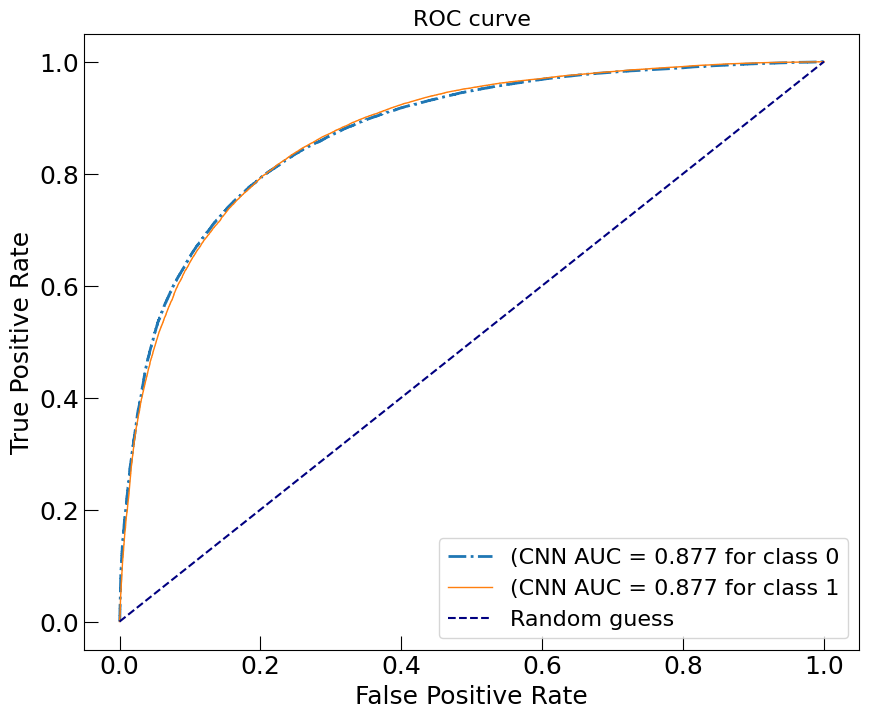

In [ ]:
roc_data_cnn = plot_roc_curves(dummy_y_test, predictions_test_numpy, n_classes, linestyles, linewidthss, 'CNN')

Text(0, 0.5, 'True Positive Rate')

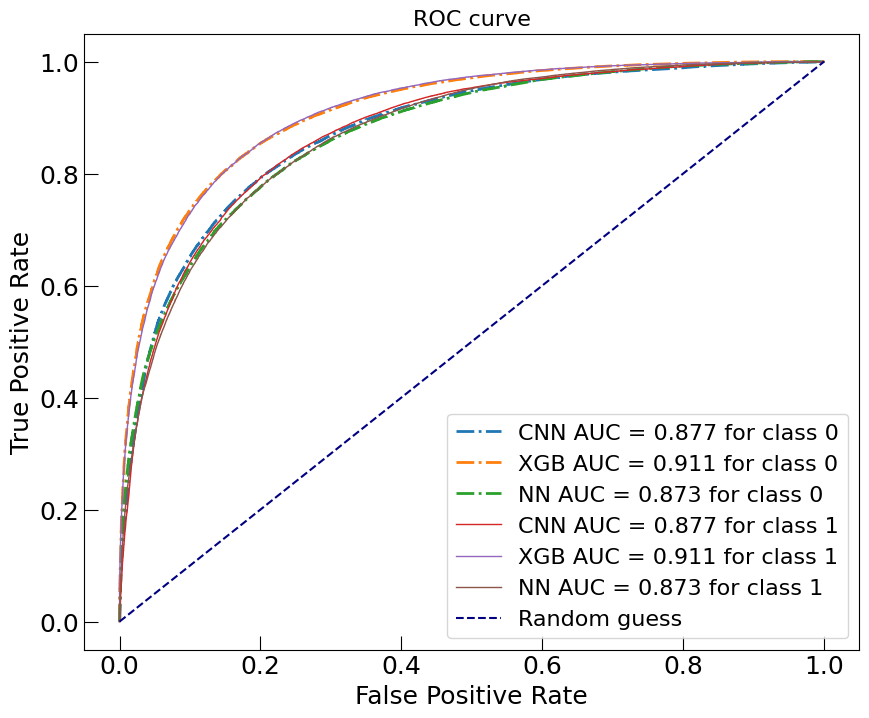

In [ ]:
fig, ax =plt.subplots(figsize=(10,8))
for i in range(n_classes):
    plt.plot(roc_data_cnn[i]['fpr'],roc_data_cnn[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"CNN AUC = {roc_data_cnn[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data_xgb[i]['fpr'],roc_data_xgb[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"XGB AUC = {roc_data_xgb[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data[i]['fpr'], roc_data[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"NN AUC = {roc_data[i]['roc_auc']:0.3f} for class {i}")


plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
plt.title("ROC curve", fontsize=16)
plt.legend(loc='lower right',fontsize=16)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)
plt.xlabel("False Positive Rate",fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)